In [3]:
# Importing required packages 
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator, Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.algorithms import VQE
import numpy as np
import random, math
from scipy import optimize as opt


# Introduction 

Quantum computers provide a natural platform to perform simulations for the evolution of systems
Proposals of simulations of quantum field theories and experimental implementation (Zoller etc.) 
Klco et al. reducing the physical space and studying the discretized Schwinger model, proposal to study the noise restrictions they faced with the help of the mitiq package

## VQE of the ground state energy 

Through the use of physical symmetries within the system it is possible to restrict the matrix to the form 

\begin{equation}
H_{k=0,+}^{\lambda^2 = 3} =
\begin{pmatrix}
-2\mu & 2x & 0 & 0\\
2x & 1 & \sqrt{2}x & 0\\
0 & \sqrt{2}x & 2 + 2\mu & \sqrt{2}x \\
0 & 0 & \sqrt{2}x & 3 
\end{pmatrix}
\end{equation}

This 4x4 matrix can then be expressed in term of the polywords

\begin{equation}
\cal{O}_{i,j} = \frac{1}{4}\sigma_{i} \otimes \sigma_{j} 
\end{equation}
with $i,j = 0,1,2,3$ representing the Pauli matrices. Such that the hamiltonian is written as
\begin{equation}
H = \sum_{i,j} c_{i,j}\cal{O}_{i,j}
\end{equation} 
with each coefficient calculated as inner product of the matrices with the Hamiltonian (equivalent to finding the coefficients of real vector through the application of dot products) 

\begin{equation}
c_{i,j} = Tr( \cal{O}^{\dagger}H) = Tr( \cal{O}H) 
\end{equation}

which the following function will implement 

In [73]:
#Function to prepare the hamiltonian alognside the traceless one 
def Hamiltonian(mu,x):
    H = np.array([[-2*mu, 2*x, 0, 0],\
                  [2*x, 1, np.sqrt(2)*x, 0],\
                  [0, np.sqrt(2)*x, 2+2*mu, np.sqrt(2)*x],\
                  [0, 0, np.sqrt(2)*x, 3]])
    HT = H - (3/2)*np.eye(4)
    
    return H,HT

#Values used in the paper minimization
[H,HT] = Hamiltonian(0.1,0.6)
print(H)
print(HT)


#Find the eigenvalues of the matrix to see if they 
#are the same 
eigenHT,_ = np.linalg.eig(HT)
print(eigenHT)


[[-0.2         1.2         0.          0.        ]
 [ 1.2         1.          0.84852814  0.        ]
 [ 0.          0.84852814  2.2         0.84852814]
 [ 0.          0.          0.84852814  3.        ]]
[[-1.7         1.2         0.          0.        ]
 [ 1.2        -0.5         0.84852814  0.        ]
 [ 0.          0.84852814  0.7         0.84852814]
 [ 0.          0.          0.84852814  1.5       ]]
[-2.51163997 -0.39739922  0.76804891  2.14099028]


In [94]:
def decomposition_H(H):

    
    #Definition of the pauli matrices 
    sigma_0 = np.eye(2)
    sigma_X = np.array([[0,1],[1,0]])
    sigma_Y = np.array([[0,-1j],[1j,0]])
    sigma_Z = np.array([[1,0],[0,-1]])
    Pauli = [sigma_0,sigma_X,sigma_Y,sigma_Z]
    Pauli_name = ['I','X','Y','Z']
    
    #Creaiton of the pauli_words
    ii = 0 
    Poly = []
    Poly_name = []
    for i in Pauli:
        jj = 0
        for j in Pauli:
            Poly.append(np.kron(i,j))
            Poly_name.append(Pauli_name[ii] + Pauli_name[jj])
            jj += 1
        ii += 1

    
    #Doing the partial trace for the coefficinets 
    c = {}
    for i in range(len(Poly)):
        c[Poly_name[i]] = np.trace(np.matmul(Poly[i],H))/4
        
    return c
    
coef = decomposition_H(HT)
coef

{'II': 0.0,
 'IX': 1.0242640687119284,
 'IY': 0j,
 'IZ': -0.49999999999999994,
 'XI': 0.0,
 'XX': 0.4242640687119285,
 'XY': 0j,
 'XZ': 0.0,
 'YI': 0j,
 'YX': 0j,
 'YY': (0.4242640687119285+0j),
 'YZ': 0j,
 'ZI': -1.1,
 'ZX': 0.17573593128807144,
 'ZY': 0j,
 'ZZ': -0.10000000000000003}

Supposing we already have the decomposition then we can then express the expectation value of the energy of the hamiltonian as 

\begin{equation} 
    \left< H \right>_{\theta} = \sum_{i}c_{i} \big< \psi(\vec{\theta}) \big| \cal{O}_{i} \big| \psi(\vec{\theta})\big>
\end{equation}

where the initial state $\big| \psi(\vec{\theta})\big> $ is determined to an specific anzats created by the circuit in E10  

To properly implement in qiskit we use the RX,RY and RZ defined as 
 
\begin{align*} 
RX(\theta) &= e^{-i\theta\frac{\sigma_{X}}{2}} \\ 
RY(\theta) &= e^{-i\theta\frac{\sigma_{Y}}{2}} \\
RZ(\theta) &= e^{-i\theta\frac{\sigma_{Z}}{2}} \\ 
\end{align*}

The created circuit is such that 

\begin{equation}
    \big| \psi(\vec{\theta})\big> = U( \vec{\theta} ) \big| \vec{0} \big>
\end{equation}

In order to find the expected value it is usefu to consider a general qubit of the form 

\begin{equation}
    \big| \psi \big> = p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> 
\end{equation}

and consider the result of the expetation value of this state with a $\sigma_{Z} \otimes \sigma_{Z}$

\begin{split}
   \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \big| \psi \big> &= \big< \psi \big| \sigma_{Z} \otimes \sigma_{Z} \Big(  p_{00}\big| 00 \big> + p_{01}\big| 01 \big> + p_{10}\big| 10 \big> + p_{11}\big| 11 \big> \Big) \\
   &=  \big< \psi \big| \Big(  p_{00}\big| 00 \big> - p_{01}\big| 01 \big> - p_{10}\big| 10 \big> + p_{11}\big| 11 \big>   \Big) \\
   &=  |p_{00}|^2 + |p_{11}|^2 - \big( |p_{10}|^2 + |p_{01}|^2  \big)
\end{split}

so in order to measure the expectation value from the results of an experiment, we just need to sum the counts with the formula above. For the case when the other pauli matrices appear there only needs to be a change in the basis of the measurements as 

\begin{align*}
\sigma_{X} &= (H)^{\dagger} \sigma_{Z} H \\
\sigma_{Y} &= (HS^{\dagger})^{\dagger} \sigma_{Z} HS^{\dagger}
\end{align*}



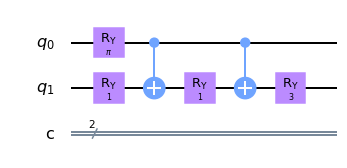

In [75]:
def State_Preparation(theta):

    qc = QuantumCircuit(2,2)
    
    qc.ry(theta[1],0)
    qc.ry(theta[0],1)
    qc.cnot(0,1)
    qc.ry(theta[0],1)
    qc.cnot(0,1)
    qc.ry(theta[2],1)
    
    return qc

#Example circuit 
qc = State_Preparation([1,math.pi,3])
qc.draw('mpl')


We are using the qasm_simulator because it mimicks the behaviour of an actual device (https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html)

Give that we want to use mitiq to find 

In [144]:
def expectation_measurement(qc,coef,shots=10000,backend = 'qasm_simulator'):

    qc_state = qc.copy() #Save original state of quantum circuit
    i = 0 #keeping track of which state
    #Loop over possible gates
    list_circuit = []
    count = []
    for key in coef.keys():
        qc_state = qc.copy() #Recover the original circuit
#        if coef[key] == 0:   #Don't calculate expectation value if it doesn't have representaiton 
#            continue 
#        else:

            #Add pauli gates for different expectation values
        for q in range(2): #Lopp over two qubits
            if key[q] == 'I' or key[q] == 'Z':
                continue
            elif key[q] == 'X':
                qc_state.h(q)
            elif key[q] == 'Y':
                qc_state.sdg(q)
                qc_state.h(q)


        #Add measurement to the circut
        qc_state.measure([0,1], [0,1])

        #Run the circuit 
        job = execute(
        experiments=qc_state,
        #backend=provider.get_backend("machine name") to run on hardware
        backend=Aer.get_backend(backend),
        optimization_level=0, shots=shots
        )

        #Extract the results counts 
        counts = job.result().get_counts()

        #Insert missing counts in case they're zero
        if '00' not in counts:
            counts['00'] = 0
        if '01' not in counts:
            counts['01'] = 0
        if '10' not in counts:
            counts['10'] = 0
        if '11' not in counts:
            counts['11'] = 0 


        if key[0] == 'I':
            if key[1] == 'I':
                # Case + + + +
                total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                exp_counts = total_counts
                exp[key] = exp_counts/total_counts

            else: 
                # Case + - + - 
                total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                exp_counts = counts['00'] + counts['01'] - counts['10'] - counts['11']
                exp[key] = exp_counts/total_counts
        else:
            if key[1] == 'I':
                #Case + + - -
                total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                exp_counts = counts['00'] - counts['01'] + counts['10'] - counts['11']
                exp[key] = exp_counts/total_counts

            else:
                #Case + - - +
                total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
                exp_counts = counts['00'] - counts['01'] - counts['10'] + counts['11']
                exp[key] = exp_counts/total_counts

        list_circuit.append(qc_state)
        count.append(counts)
        return exp

qc = State_Preparation([0,0,0])
exp = expectation_measurement(qc,coef)
exp 
#coef

{'II': 1.0,
 'IX': 0.0062,
 'IY': 0j,
 'IZ': -0.49999999999999994,
 'XI': 0.0,
 'XX': 0.4242640687119285,
 'XY': 0j,
 'XZ': 0.0,
 'YI': 0j,
 'YX': 0j,
 'YY': (0.4242640687119285+0j),
 'YZ': 0j,
 'ZI': -1.1,
 'ZX': 0.17573593128807144,
 'ZY': 0j,
 'ZZ': -0.10000000000000003}

Now we are in a position to construct the function to construct the function that gives the result of the expectation value 

In [100]:
def Expectation_Hamiltonian(theta,H,shots=10000,backend = 'qasm_simulator'):

    #Find the Pauli decomposition
    c = decomposition_H(H)
    
    #Define the wavefunction anzats 
    qc = State_Preparation(theta)
    
    #Expectation value for Pauli matrices
    exp = expectation_measurement(qc,c,shots,backend)
    
    #Expectation value of hamiltonian 
    H_exp = 0
    for key in c.keys():
        print(c[key],exp[key])
        H_exp += c[key]*exp[key]
        
    return H_exp

theta =[2.04080785, 3.00670891, 0.56948234]
Expectation_Hamiltonian(theta,HT)
    

0.0 0.0
1.0242640687119284 0.527
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003


(2.400670281756872+0j)

We can construct now an optimization using COBYLA method that was found in the application process to be the most effecient one, as well as the recommended one inn the qiskit tutorial for VQE (https://qiskit.org/textbook/ch-applications/vqe-molecules.html). We will be using the scipy optimization package 




In [98]:
theta_0 = 2*math.pi*np.random.random([3]) #Initial random values

opt.bounds = (0,2*math.pi) #setting the bounds for the optimizaiton

sol = opt.minimize(Expectation_Hamiltonian,theta_0,args=(HT),method='COBYLA')
print(sol)


0.0 0.0
1.0242640687119284 0.393
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 0.6144
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 0.3874
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 0.8782
0j 0j
-0.49999999999999994 -0.49999999999999994
0

C:\Users\javie\anaconda3\envs\qiskit_env\lib\site-packages\scipy\optimize\cobyla.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = _cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


0.0 0.0
1.0242640687119284 -0.61
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 -0.4404
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 -0.61
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 -0.8448
0j 0j
-0.49999999999999994 -0.49999999999999994


0.0 0.0
1.0242640687119284 -0.999
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 -0.9972
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 -0.9994
0j 0j
-0.49999999999999994 -0.49999999999999994
0.0 0.0
0.4242640687119285 0.4242640687119285
0j 0j
0.0 0.0
0j 0j
0j 0j
(0.4242640687119285+0j) (0.4242640687119285+0j)
0j 0j
-1.1 -1.1
0.17573593128807144 0.17573593128807144
0j 0j
-0.10000000000000003 -0.10000000000000003
0.0 0.0
1.0242640687119284 -0.9992
0j 0j
-0.49999999999999994 -0.499999999999999

In [79]:
HT

array([[-1.7       ,  1.2       ,  0.        ,  0.        ],
       [ 1.2       , -0.5       ,  0.84852814,  0.        ],
       [ 0.        ,  0.84852814,  0.7       ,  0.84852814],
       [ 0.        ,  0.        ,  0.84852814,  1.5       ]])

To use mitiq with just a few lines of code, we simply need to define a function which inputs a circuit and outputs the expectation value to mitigate. This function will:

Add measurement(s) to the circuit.

Run the circuit.

Convert from raw measurement statistics (or a different output format) to an expectation value.

We define this function in the following code block. Because we are using IBMQ backends, we first load our account.

## Implementation with pre-existing algorithm 

In [ ]:
vqe = VQE()

In [254]:
from qiskit.aqua.operators import WeightedPauliOperator

pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}


qubit_op = WeightedPauliOperator.from_dict(coef)
pauli_dict

AquaError: 'Dictionary missing "paulis" key'